The aim of this study is to consider different machine learning techniques for the task of determining whether an image is generated or not in the context of small samples(~1000 objects).


# Data collection
Dataset taken from a kaggle competition https://www.kaggle.com/competitions/generated-or-not/leaderboard

In [1]:
import os
from zipfile import ZipFile
from shutil import move

kaggle_dir = os.path.join(os.path.expanduser("~"), ".kaggle")
if not os.path.exists(kaggle_dir):
    os.makedirs(kaggle_dir)

kaggle_json_path = os.path.join(kaggle_dir, "kaggle.json")
if not os.path.exists(kaggle_json_path):
    move("kaggle.json", kaggle_dir)
    os.chmod(kaggle_json_path, 0o600)

!kaggle competitions download -c generated-or-not

with ZipFile('generated-or-not.zip', 'r') as zip_ref:
    zip_ref.extractall('generated-or-not')


generated-or-not.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
with ZipFile('generated-or-not.zip', 'r') as zip_ref:
    zip_ref.extractall('')

Let's divide our sample into a training sample and a test sample, and divide them into two classes - generated image or real image.

In [3]:
import os
import shutil
import pandas as pd

def get_image_extension(image_name):
    return os.path.splitext(image_name)[1]

def get_image_extension_from_dir(image_name):
    for file_name in os.listdir('images/'):
        if file_name.startswith(image_name):
            return os.path.splitext(file_name)[1]
    return None

def move_images_to_train(csv_path):
    fake_folder = os.path.join('train', 'fake')
    real_folder = os.path.join('train', 'real')
    os.makedirs(fake_folder, exist_ok=True)
    os.makedirs(real_folder, exist_ok=True)

    df = pd.read_csv(csv_path)
    for index, row in df.iterrows():
        image_name = row['id']
        label = row['target']

        image_name_has_extension = True

        image_extension = get_image_extension(image_name)

        if not image_extension:
            image_name_has_extension = False
            image_extension = get_image_extension_from_dir(image_name)
            
        desr_folder = ''
        
        if label == 1:
          dest_folder = fake_folder
        else:
          dest_folder = real_folder

        if image_name_has_extension == False:
          dest_path = os.path.join(dest_folder, image_name + image_extension)
          shutil.copy(os.path.join('images', image_name + image_extension), dest_path)
        else:
          dest_path = os.path.join(dest_folder, image_name)
          shutil.copy(os.path.join('images', image_name), dest_path)

def move_images_to_test(csv_path):
    dest_folder = os.path.join('test')
    os.makedirs(dest_folder, exist_ok=True)

    df = pd.read_csv(csv_path)
    for index, row in df.iterrows():
        image_name = row['id']

        image_name_has_extension = True

        image_extension = get_image_extension(image_name)

        if not image_extension:
            image_name_has_extension = False
            image_extension = get_image_extension_from_dir(image_name)

        if image_name_has_extension == False:
          dest_path = os.path.join(dest_folder, image_name + image_extension)
          shutil.copy(os.path.join('images', image_name + image_extension), dest_path)
        else:
          dest_path = os.path.join(dest_folder, image_name)
          shutil.copy(os.path.join('images', image_name), dest_path)

move_images_to_train('train.csv')
move_images_to_test('test.csv')

print("The images have been successfully divided into folders 'train/fake', 'train/real', и 'test")


Изображения успешно разделены на папки 'train/fake', 'train/real', и 'test


Let's check to see if we lost any pictures in the sorting process.


In [4]:
import os

train_fake_dir = 'train/fake'
train_real_dir = 'train/real'
test_dir = 'test'
all_dir = 'images'
train_fake_files = os.listdir(train_fake_dir)
train_real_files = os.listdir(train_real_dir)
test_files = os.listdir(test_dir)
all_files = os.listdir(all_dir)

if (len(train_fake_files) + len(train_real_files) + len(test_files) == len(all_files)):
  print("All files are sorted!")
else:
  print("Some file got lost!")

Все файлы рассортированы!


# Exploratory data analysis


### Class distribution

In [5]:
print('Proportion of generated images in train: ', len(train_fake_files) / (len(train_fake_files) + len(train_real_files)))
print('Proportion of real images in the train: ', len(train_real_files) / (len(train_fake_files) + len(train_real_files)))

Доля сгенерированных изображений в train:  0.3409090909090909
Доля настоящих изображений в train:  0.6590909090909091


Class imbalance is present, but it is not critical.


### Analysing the correlation between picture size and class membership.

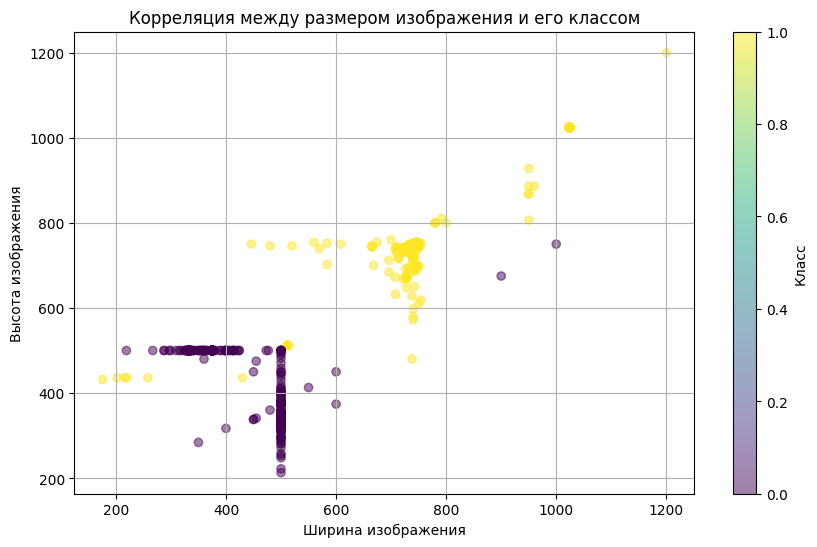

In [6]:
from PIL import Image
import os
import matplotlib.pyplot as plt

size = []

for img_file in train_fake_files:
    img_path = os.path.join(train_fake_dir, img_file)
    with Image.open(img_path) as img:
        width, height = img.size
        size.append((width, height, 1))

for img_file in train_real_files:
    img_path = os.path.join(train_real_dir, img_file)
    with Image.open(img_path) as img:
        width, height = img.size
        size.append((width, height, 0))

df = pd.DataFrame(size, columns=['width', 'height', 'class'])

plt.figure(figsize=(10, 6))
plt.scatter(df['width'], df['height'], c=df['class'], alpha=0.5)
plt.title('Correlation between image size and image class')
plt.xlabel('Image width')
plt.ylabel('Image height')
plt.colorbar(label='Class')
plt.grid(True)
plt.show()


Some patterns are definitely present.


### Finding a correlation between the class of an image and the statistical analysis of its pixels.

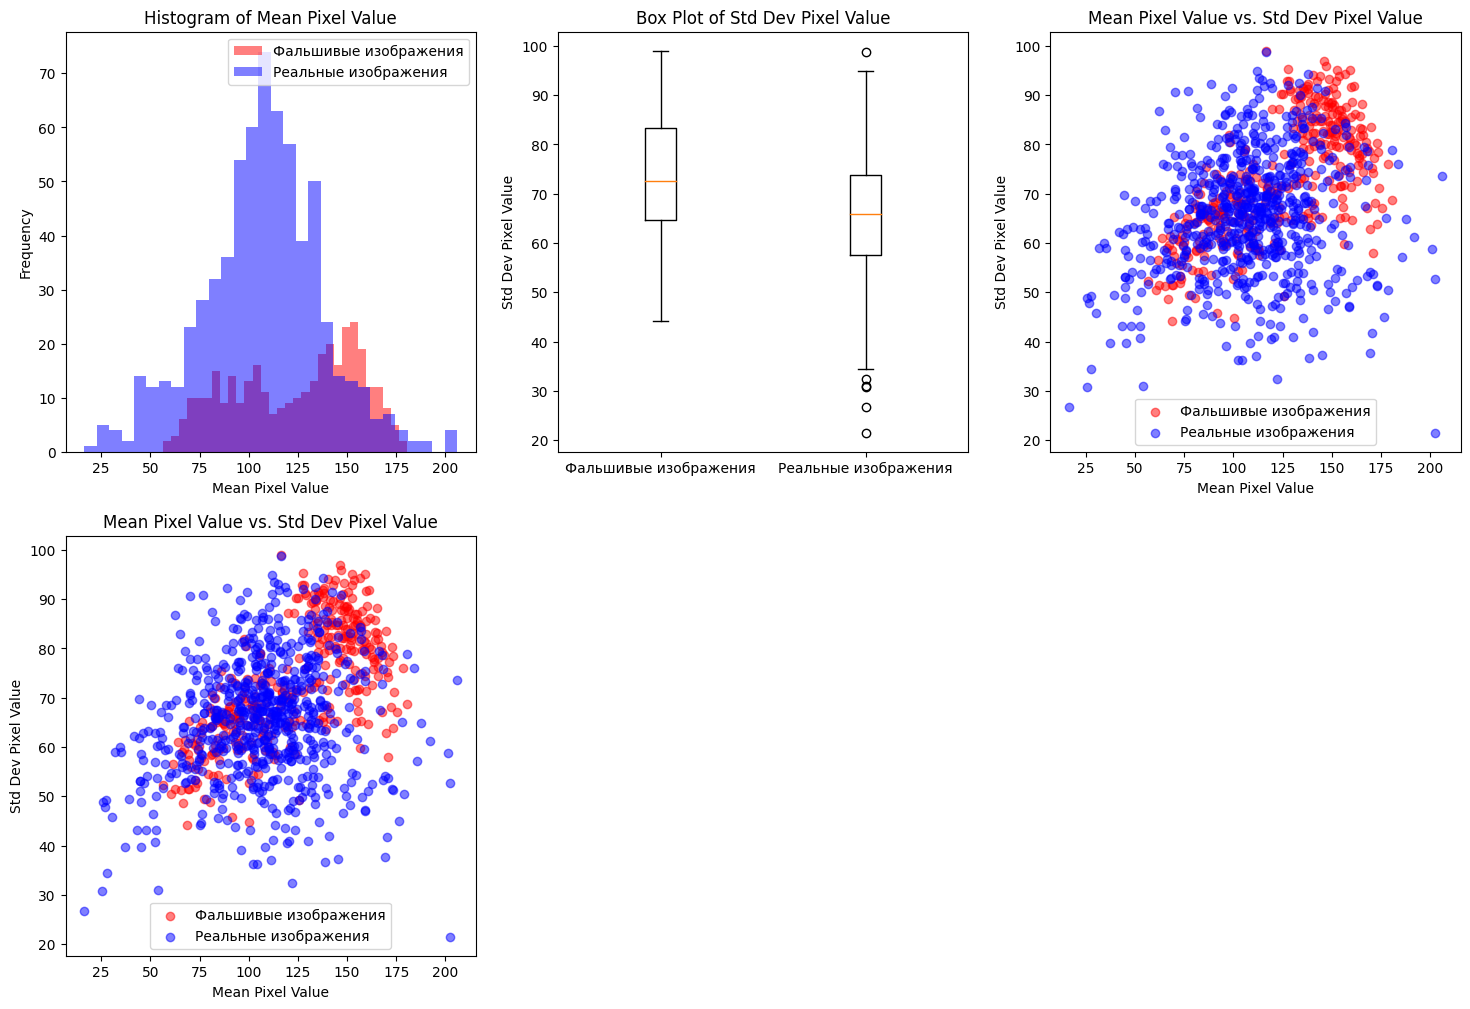

In [7]:
import numpy as np

fake_pixels_info = []
real_pixels_info = []

for img_file in train_fake_files:
    img_path = os.path.join(train_fake_dir, img_file)
    with Image.open(img_path) as img:
        img_array = np.array(img)
        mean_pixel_value = np.mean(img_array)
        std_dev_pixel_value = np.std(img_array)
        fake_pixels_info.append((mean_pixel_value, std_dev_pixel_value))

for img_file in train_real_files:
    img_path = os.path.join(train_real_dir, img_file)
    with Image.open(img_path) as img:
        img_array = np.array(img)
        mean_pixel_value = np.mean(img_array)
        std_dev_pixel_value = np.std(img_array)
        real_pixels_info.append((mean_pixel_value, std_dev_pixel_value))

fake_mean_values = [x[0] for x in fake_pixels_info]
fake_std_dev_values = [x[1] for x in fake_pixels_info]

real_mean_values = [x[0] for x in real_pixels_info]
real_std_dev_values = [x[1] for x in real_pixels_info]

plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
plt.hist(fake_mean_values, color='red', bins=30, alpha=0.5, label='Fake images')
plt.hist(real_mean_values, color='blue', bins=30, alpha=0.5, label='Real images')
plt.title('Histogram of Mean Pixel Value')
plt.xlabel('Mean Pixel Value')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(2, 3, 2)
plt.boxplot([fake_std_dev_values, real_std_dev_values], labels=['Fake images', 'Real images'])
plt.title('Box Plot of Std Dev Pixel Value')
plt.ylabel('Std Dev Pixel Value')

plt.subplot(2, 3, 3)
plt.scatter(fake_mean_values, fake_std_dev_values, color='red', label='Fake images', alpha=0.5)
plt.scatter(real_mean_values, real_std_dev_values, color='blue', label='Real images', alpha=0.5)
plt.title('Mean Pixel Value vs. Std Dev Pixel Value')
plt.xlabel('Mean Pixel Value')
plt.ylabel('Std Dev Pixel Value')
plt.legend()

plt.subplot(2, 3, 4)
plt.scatter(fake_mean_values, fake_std_dev_values, color='red', label='Fake images', alpha=0.5)
plt.scatter(real_mean_values, real_std_dev_values, color='blue', label='Real images', alpha=0.5)
plt.title('Mean Pixel Value vs. Std Dev Pixel Value')
plt.xlabel('Mean Pixel Value')
plt.ylabel('Std Dev Pixel Value')
plt.legend()

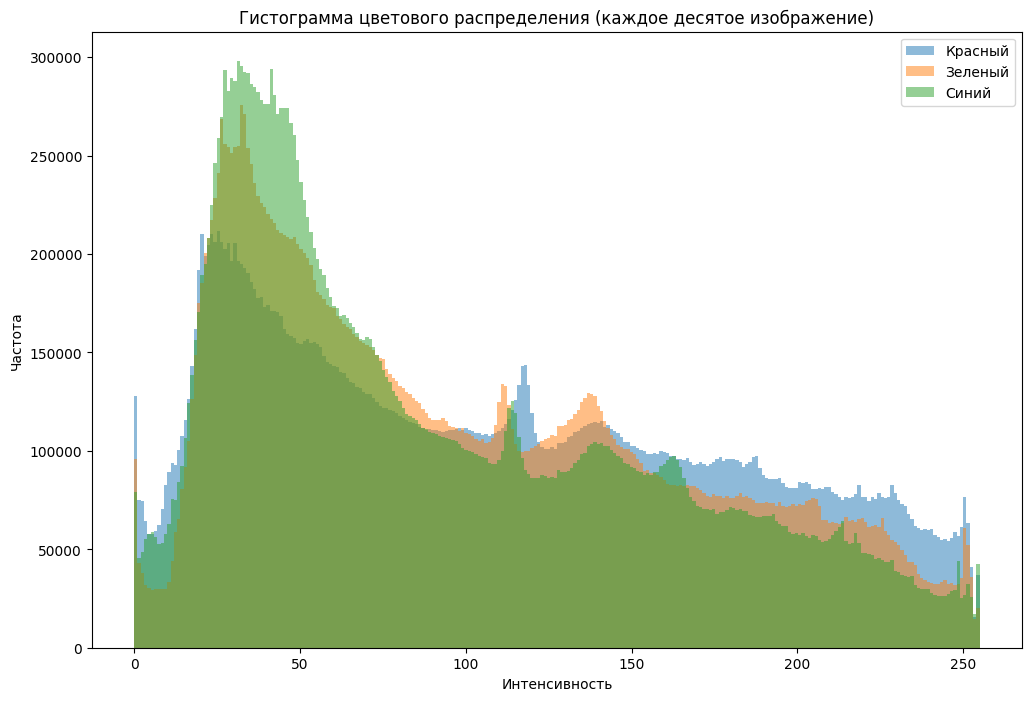

In [8]:
import matplotlib.pyplot as plt

fake_red_color = []
fake_green_color = []
fake_blue_color = []

counter = 0

for img_file in train_fake_files:
    if counter % 10 == 0:
        img_path = os.path.join(train_fake_dir, img_file)
        with Image.open(img_path) as img:
            img_array = np.array(img)
            rgb_image = img_array if img_array.ndim == 3 else np.stack((img_array,) * 3, axis=-1)
            fake_red_color.extend(rgb_image[:, :, 0].ravel())
            fake_green_color.extend(rgb_image[:, :, 1].ravel())
            fake_blue_color.extend(rgb_image[:, :, 2].ravel())
    counter += 1

plt.figure(figsize=(12, 8))

plt.hist(fake_red_color, bins=256, alpha=0.5, label='Red')

plt.hist(fake_green_color, bins=256, alpha=0.5, label='Green')

plt.hist(fake_blue_color, bins=256, alpha=0.5, label='Blue')

plt.title('Colour distribution histogram (every tenth fake image)')
plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.legend()

plt.show()


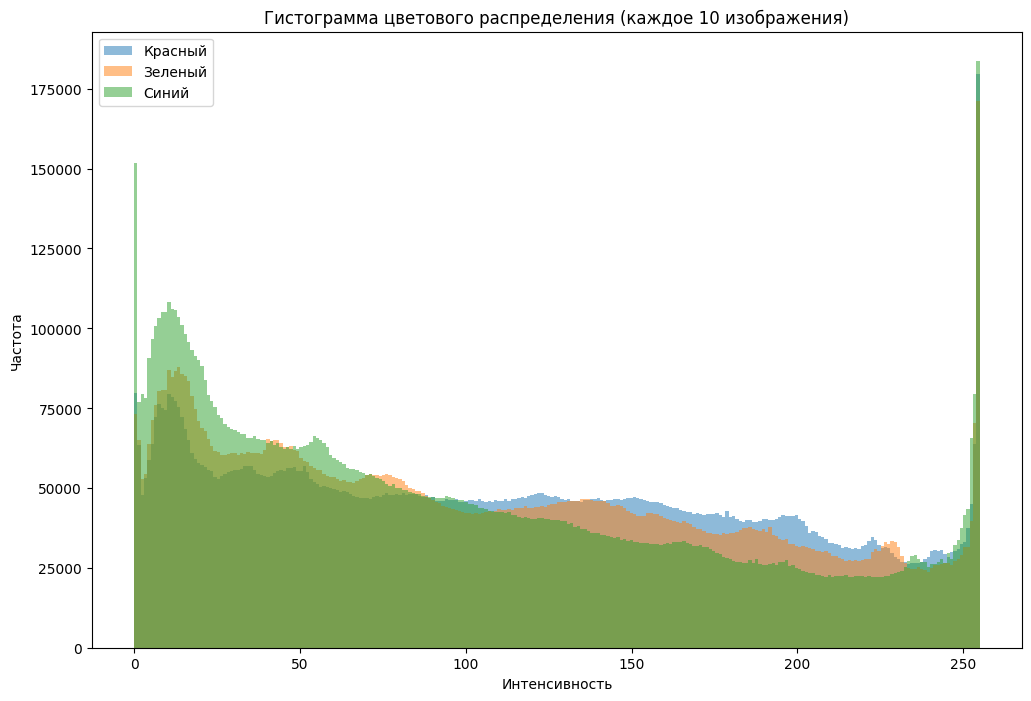

In [9]:
import matplotlib.pyplot as plt

real_red_color = []
real_green_color = []
real_blue_color = []

counter = 0

for img_file in train_real_files:
    if counter % 10 == 0:
        img_path = os.path.join(train_real_dir, img_file)
        with Image.open(img_path) as img:
            img_array = np.array(img)
            rgb_image = img_array if img_array.ndim == 3 else np.stack((img_array,) * 3, axis=-1)
            real_red_color.extend(rgb_image[:, :, 0].ravel())
            real_green_color.extend(rgb_image[:, :, 1].ravel())
            real_blue_color.extend(rgb_image[:, :, 2].ravel())
    counter += 1

plt.figure(figsize=(12, 8))

plt.hist(real_red_color, bins=256, alpha=0.5, label='Red')

plt.hist(real_green_color, bins=256, alpha=0.5, label='Green')

plt.hist(real_blue_color, bins=256, alpha=0.5, label='Blue')

plt.title('Colour distribution histogram (every tenth real image)')
plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.legend()

plt.show()

As a result, we noticed differences in: the frequency of the average pixel value, the presence of outliers in the standard deviation and the colour distribution. We will try to use it in the future.

# Trying different models

### XGBoost on histograms of colour distributions

In [10]:
histograms = []
labels = []

def create_histogram(image_path):
    with Image.open(image_path) as img:
        img_array = np.array(img)
        rgb_image = img_array if img_array.ndim == 3 else np.stack((img_array,) * 3, axis=-1)
        red_hist = np.histogram(rgb_image[:, :, 0], bins=256, range=(0, 256))[0]
        green_hist = np.histogram(rgb_image[:, :, 1], bins=256, range=(0, 256))[0]
        blue_hist = np.histogram(rgb_image[:, :, 2], bins=256, range=(0, 256))[0]
        histogram = np.concatenate([red_hist, green_hist, blue_hist])
        
        return histogram

for img_file in train_real_files:
    img_path = os.path.join(train_real_dir, img_file)
    histogram = create_histogram(img_path)
    histograms.append(histogram)
    labels.append(1) 
    
for img_file in train_fake_files:
    img_path = os.path.join(train_fake_dir, img_file)
    histogram = create_histogram(img_path)
    histograms.append(histogram)
    labels.append(0)

histograms = np.array(histograms)
labels = np.array(labels)

In [11]:
!pip install xgboost


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [28]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import xgboost as xgb

X = histograms  
y = labels 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

XGB = xgb.XGBClassifier(
    max_depth=5,
    learning_rate=0.1,
    n_estimators=100,
    objective='binary:logistic' 
)

XGB.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='logloss', verbose=False)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1] 

logloss = log_loss(y_test, y_pred_proba)
print("Log Loss:", logloss)

Log Loss: 0.08539591185737004


In [18]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import log_loss

X = histograms  
y = labels 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

params_list = [
    {'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 100, 'objective': 'binary:logistic'},
    {'max_depth': 5, 'learning_rate': 0.05, 'n_estimators': 200, 'objective': 'binary:logistic'},
    {'max_depth': 4, 'learning_rate': 0.07, 'n_estimators': 150, 'objective': 'binary:logistic'}
]

models = []
for params in params_list:
    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)
    models.append(model)

X_train_meta = np.zeros((X_train.shape[0], len(models)))

for idx, model in enumerate(models):
    X_train_meta[:, idx] = model.predict_proba(X_train)[:, 1]

X_test_meta = np.zeros((X_test.shape[0], len(models)))
for idx, model in enumerate(models):
    X_test_meta[:, idx] = model.predict_proba(X_test)[:, 1]

meta_model = xgb.XGBClassifier(max_depth=4, learning_rate=0.1, n_estimators=100, objective='binary:logistic')
meta_model.fit(X_train_meta, y_train)

final_pred = meta_model.predict_proba(X_test_meta)[:, 1]

final_log_loss = log_loss(y_test, final_pred)
print("Final Log Loss:", final_log_loss)


Final Log Loss: 0.1446832221837797


### KNN on image dimensions

In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss
import random

image_sizes = []

knn_labels = []

for img_file in train_real_files:
    img_path = os.path.join(train_real_dir, img_file)
    with Image.open(img_path) as img:
        width, height = img.size
        image_sizes.append([width, height])
        knn_labels.append(1)

for img_file in train_fake_files:
    img_path = os.path.join(train_fake_dir, img_file)
    mg_path = os.path.join(train_real_dir, img_file)
    with Image.open(img_path) as img:
        width, height = img.size
        image_sizes.append([width, height])
        knn_labels.append(0)

        
combined = list(zip(image_sizes, knn_labels))
random.shuffle(combined)
image_sizes, knn_labels = zip(*combined)

X = image_sizes
y = knn_labels

X_train, X_test, y_train, y_test = train_test_split(image_sizes, knn_labels, test_size=0.2, random_state=42)

knn_classifier = KNeighborsClassifier()

param_grid = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

grid_search = GridSearchCV(knn_classifier, param_grid, scoring='neg_log_loss')

grid_search.fit(X_train, y_train)

best_knn_model = grid_search.best_estimator_

y_pred = best_knn_model.predict(X_test)

logloss = log_loss(y_test, y_pred)
print("Log Loss:", logloss)

best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Log Loss: 2.220446049250313e-16
Best Parameters: {'n_neighbors': 3}


### These results make us realise that, due to the small amount of training data, even solutions that do not use neural network approaches perform well.

### Because of the small size of the dataset knn gives a perfect logloss, but it is unlikely to work well on test data.

In [38]:
import numpy as np
import pandas as pd

# Создание гистограмм для тестовых изображений
histograms_test = []
for img_file in test_files:
    img_path = os.path.join(test_dir, img_file)
    histogram = create_histogram(img_path)
    histograms_test.append(histogram)
histograms_test = np.array(histograms_test)    

# Создание мета-признаков для тестового набора данных
X_test_meta = np.zeros((histograms_test.shape[0], len(models)))
for idx, model in enumerate(models):
    X_test_meta[:, idx] = model.predict_proba(histograms_test)[:, 1]

# Предсказание на тестовом наборе данных с помощью мета-модели
final_pred = meta_model.predict_proba(X_test_meta)[:, 1]

# Загрузка идентификаторов тестовых изображений из test.csv
test_data = pd.read_csv('test.csv')
test_ids = test_data['id']

# Создание DataFrame с предсказаниями
predictions_df = pd.DataFrame({'id': test_ids, 'target': final_pred})

# Запись предсказаний в CSV файл
predictions_df.to_csv('predictions.csv', index=False)


# Conclusion

### The log-loss of the final ensemble was 0.08 on the test data. So, we can say that on small amounts of data, non-neural network solutions can also give good prediction quality.